XGBoost model for prediction of Time to Failure

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_squared_error
import h5py

In [2]:


def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'TTF':data['TTF'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3787:136186].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'Vel_pc', 'maxFreqI_filt', 'TTF']]
print("Input data:\n", df)



Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc  ...  maxFreqI_filt  TTF
0         31438.277060                0.0  ...  457680.400524  0.0
1         31421.341616                0.0  ...  457727.638932  0.0
2         31409.798761                0.0  ...  457770.778724  0.0
3         31398.815589                0.0  ...  457811.889181  0.0
4         31395.584981                0.0  ...  457775.514596  0.0
...                ...                ...  ...            ...  ...
132394    31041.955345                0.0  ...  454414.128118  0.0
132395    31035.059531                0.0  ...  454404.028108  0.0
132396    31020.001291                0.0  ...  454403.709700  0.0
132397    31012.016780                0.0  ...  454398.871858  0.0
132398    31010.874482                0.0  ...  454410.333590  0.0

[132399 rows x 6 columns]


In [4]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 5)
Target shape, Y =  (132099,)
After reshaping, X =  (132099, 1500)


In [5]:
# Split into train-val-test

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)   
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95111, 1500)
Validation: (10568, 1500)
Testing: (26420, 1500)


In [ ]:
# Parameter tuning

params = {
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [200, 600, 1000],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 9],
        'objective':['reg:squarederror']
        }

best_score = 0

for g in ParameterGrid(params):
  model = XGBRegressor()
  model.set_params(**g)
  model.fit(X_train, Y_train)
  y_predVal = model.predict(X_val)
  val_r2 = r2_score(Y_val, y_predVal)
  if val_r2 > best_score:
    best_score = val_r2
    best_grid = g
#print(best_grid)


In [7]:
# Train the model

#model = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=600, objective='reg:squarederror')
model = XGBRegressor()
model.set_params(**best_grid)
start_time = time.time()
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=False, early_stopping_rounds = 40)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

---Training time: 7337.15019512 seconds ---


In [8]:
# Evaluate the model

y_predTrain = model.predict(X_train)
y_predTrain = np.clip(y_predTrain, a_min=0, a_max=None)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
y_predVal = np.clip(y_predVal, a_min=0, a_max=None)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

y_predTest = model.predict(x_test)
y_predTest = np.clip(y_predTest, a_min=0, a_max=None)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)


R^2 scores:  0.9933215763972236 0.9130632879007986 0.8318471999238175
RMSE:  0.08565893415619752 0.3398876306673559 0.4708878962645495


In [ ]:
# Save the predictions
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/res300/xgb_ttf.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''

Text(0.5, 1.0, 'Time to Failure prediction using XGBoost model')

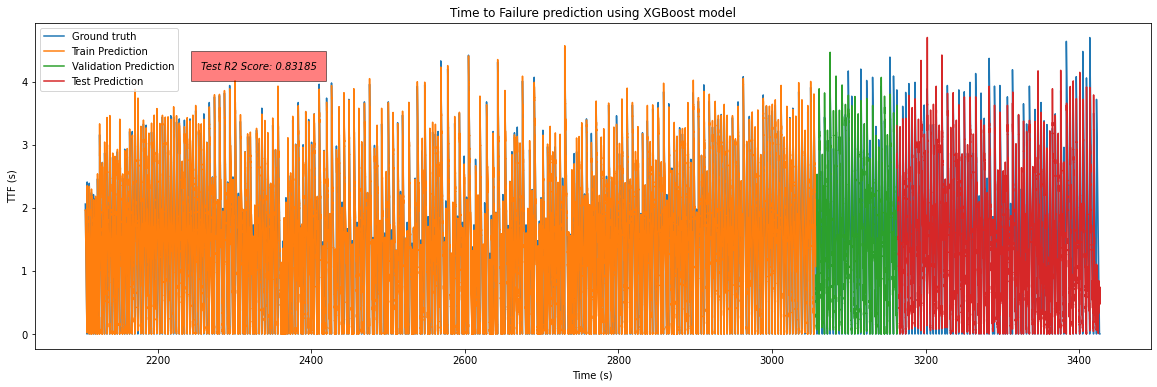

In [10]:
# Overall plot

ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.text(ttime.iloc[15000], 4.2, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Time to Failure prediction using XGBoost model')


Text(0.5, 1.0, 'Detailed View, Testing Data')

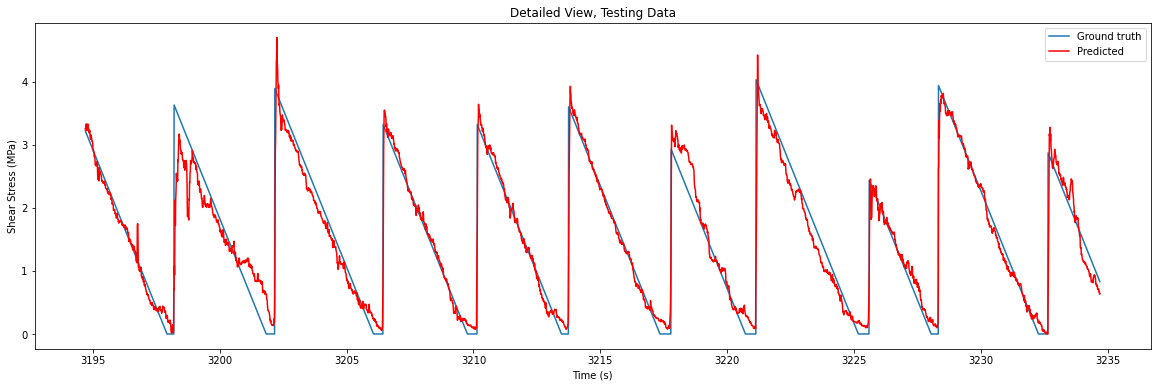

In [11]:
# Detailed plot (test data)

n = 4000
st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


In [12]:
# Plot Feature importance 
#plot_importance(model.get_booster().get_score(importance_type='gain'))